In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle

In [2]:
def unPackRawFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    return distance, pec_vel, temp, HI_density
def unPackDenFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    HI_fraction = y[:,1]
    gas_density  = y[:,2]
    temperature = y[:,3]
    return distance, HI_fraction,gas_density, temperature
   
    return distance, gas_density
def getPos(path_LOS,linenumber=5):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=5):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    data = []
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        den_path =  'los.00' + '{0:03}'.format(i) +'.den'
        distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance1,HI_fraction,gas_density1,temperature = unPackDenFile(den_path)
        distance_cm = distance *0.1452*3.086e24 /0.68
        gas_density =sp.interpolate.interp1d(distance1,gas_density1, fill_value="extrapolate")(distance)
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k+1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40   ]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(area_under >= (1.6*10**17)and area_under  <= (10**22)):
                        data.append(area_under)
    return data
lyman_limited_value = lyman_identification()


In [3]:
len(lyman_limited_value)

1273

In [4]:
with open('a_lyman_limited_value.pkl', 'rb') as f:
    lyman = pickle.load(f)

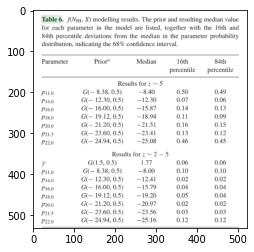

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('overplotting.png')
imgplot = plt.imshow(img)
plt.show()

In [6]:
column_density_spacing = [10**11,10**14,10**16,10**18,10**20,10**21.5,10**22]

In [7]:
x_axis_2= [11.0,14.0000,16,18,20,21.5,22]


In [8]:
median = [10**-8.4,10**-12.3,10**-15.87,10**-18.94,10**-21.51,10**-23.41,10**-25.08]

In [9]:
mean = [10**-8.38,10**-12.30,10**-16.00,10**-19.12,10**-21.20,10**-23.60,10**-24.94]

In [10]:
percentile_16th  = [10**(-8.38-.5),10**(-12.3-0.07),10**(-16.0-0.14),10**(-19.12-0.11),10**(-21.2-0.16),10**(-23.60-0.13),10**(-24.94-0.46)]

In [11]:
percentile_84th  = [10**(-8.38+.5),10**(-12.3+0.07),10**(-16.0+0.14),10**(-19.12+0.11),10**(-21.2+0.16),10**(-23.60+0.13),10**(-24.94+0.46)]

In [12]:
stuff = np.multiply(column_density_spacing,mean)

In [13]:
upper_bounds = np.multiply(np.subtract(percentile_84th, mean),column_density_spacing)

In [14]:
lower_bounds =  np.subtract(np.multiply(mean,column_density_spacing),np.multiply(percentile_16th,column_density_spacing))

In [15]:
lyman_limited_value_sorted= sorted(lyman_limited_value)

In [16]:
min_value_lyman_limited_value = np.log10(min(lyman_limited_value_sorted))
max_value_lyman_limited_value = np.log10(max(lyman_limited_value_sorted))
print(min_value_lyman_limited_value)
print(max_value_lyman_limited_value)

17.206594839896685
21.998184660634227


In [17]:
bins = np.linspace(min_value_lyman_limited_value,max_value_lyman_limited_value,51)
bins

array([17.20659484, 17.30242664, 17.39825843, 17.49409023, 17.58992203,
       17.68575382, 17.78158562, 17.87741741, 17.97324921, 18.06908101,
       18.1649128 , 18.2607446 , 18.3565764 , 18.45240819, 18.54823999,
       18.64407179, 18.73990358, 18.83573538, 18.93156718, 19.02739897,
       19.12323077, 19.21906256, 19.31489436, 19.41072616, 19.50655795,
       19.60238975, 19.69822155, 19.79405334, 19.88988514, 19.98571694,
       20.08154873, 20.17738053, 20.27321233, 20.36904412, 20.46487592,
       20.56070771, 20.65653951, 20.75237131, 20.8482031 , 20.9440349 ,
       21.0398667 , 21.13569849, 21.23153029, 21.32736209, 21.42319388,
       21.51902568, 21.61485747, 21.71068927, 21.80652107, 21.90235286,
       21.99818466])

In [18]:
bin_data = pd.DataFrame()
bin_data['cut_lyman_limited'] = np.array(lyman_limited_value_sorted)
bin_data['cut_lyman_limited'] = pd.cut(np.log10(bin_data['cut_lyman_limited']), bins = bins,include_lowest = True).astype(str)

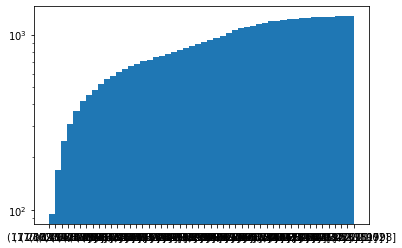

In [19]:
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
hist = ax.hist(bin_data,bins=50,cumulative =1,log =True)

In [20]:
##extract the change in column density counts
##abserve the trend that as the column density decreases the rate of number density decrease increase.
number_count = []
for i in range(1, len(hist[0])):
    number_count.append(hist[0][i]- hist[0][i-1])
total =0 
for i in number_count:
    total += i

In [21]:
#we here find the change in column density
#d_N_column = bins[1] - bins[0]
d_N_column= []
for i in range(1,50):
    d_N_column.append(10**bins[i]-10**bins[i-1])

In [22]:
def aH_calc(aexp,OmegaM):
    aH = 100*aexp*np.sqrt(OmegaM/aexp**3+(1-OmegaM))
    return aH
aH = aH_calc(aexp=0.1453,OmegaM=0.3036)
print(aH)

145.0576616872343


In [23]:
 #dN / (dz *dN_HI)
y_value = []
#dz = dv/c = H*dr/c = aH*dx/c
#dx = 100cMpc * number of line of sights
dz = (100*1000) 
for i,k in zip(number_count,d_N_column):
    y_value.append(i/(dz*(k)))

In [24]:
aH/3e5

0.00048352553895744763

In [25]:
x_value = []
for i in range(1,50):
    x_value.append(bins[i])

In [26]:
#error bar calculation starts here:

In [28]:
y_value = np.multiply(np.power(10,x_value),y_value)

In [29]:
lower_bound = []
for i in lower_bounds:
    lower_bound.append(float(i))
upper_bound = []
for i in upper_bounds:
    upper_bound.append(float(i))

In [30]:
error = [lower_bound, upper_bound]

In [31]:
#(1+z) **2 * hubble/speed of light
scale_factor = (1+5.8)**2 *68/3e5

dx/dl

In [32]:
redshift = 5.8
median_scaled = np.multiply(median,scale_factor)
error_scaled = np.multiply(error,scale_factor)

dz/dl

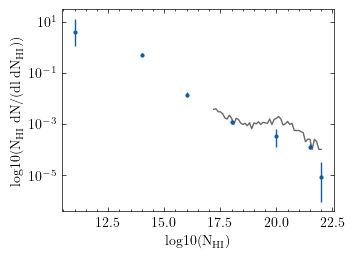

In [33]:
import matplotlib.pyplot as plt
import pickle as pickle
x_axis = np.linspace(bins[0],bins[-1],49)
with plt.style.context('science','notebook'):
    plt.figure()    
    plt.plot(x_axis,y_value,color = "dimgray")
    plt.rcParams['font.size'] = 8 
    plt.errorbar(x_axis_2, np.multiply(median_scaled,column_density_spacing),yerr = error_scaled,fmt="o",ms=2)
    plt.yscale("log")
    plt.yticks()
    plt.xlabel("$\mathrm{log10(N_{HI})}$",fontsize = 10)
    plt.ylabel("$\mathrm{log10(N_{HI}}$ $\mathrm{dN/(dl\: dN_{HI}))}$",fontsize =10)
    plt.savefig("simple_fit.pdf")

In [34]:
y_value

array([0.00378766, 0.00393917, 0.00303013, 0.00297963, 0.00252511,
       0.00171707, 0.00156557, 0.00222209, 0.00166657, 0.00095954,
       0.00166657, 0.00151506, 0.00111105, 0.00095954, 0.00106055,
       0.00085854, 0.00111105, 0.00065653, 0.00111105, 0.00101004,
       0.00121205, 0.00095954, 0.00116155, 0.00111105, 0.00106055,
       0.00156557, 0.00095954, 0.00151506, 0.00166657, 0.00196958,
       0.00156557, 0.00090904, 0.00101004, 0.00126255, 0.00095954,
       0.00106055, 0.00055552, 0.00055552, 0.00055552, 0.00050502,
       0.00045452, 0.00020201, 0.00025251, 0.00025251, 0.000101  ,
       0.00025251, 0.00020201, 0.000101  , 0.000101  ])

Crighton + 15

In [35]:
H_min = [20.300, 20.425, 20.675, 21.075, 21.300]
H_max = [20.425,20.675,21.075,21.300 ,21.800]
column_density_crighton = [-22.12,- 22.13, -22.51, -22.77,-23.77]
H_middle = np.power(10,H_min) + np.subtract(np.power(10,H_max),np.power(10,H_min))/2

In [36]:
column_density_crighton_power = np.power(10,column_density_crighton)

In [37]:
upper = np.add([ 0.24, 0.18 , 0.18, 0.14 , 0.30],column_density_crighton)
lower = np.subtract(column_density_crighton,[0.21,0.15,0.13,0.13,0.18])

In [38]:
upper_power =np.power(10,upper) - column_density_crighton_power 
lower_power = column_density_crighton_power - np.power(10,lower)

In [39]:
upper_power = upper_power*H_middle
lower_power = lower_power*H_middle


In [40]:
upper_power

array([0.0130293 , 0.01407143, 0.01318569, 0.01028332, 0.00701841])

In [41]:
lower_power = abs(lower_power)

In [42]:
lower_power

array([0.00677079, 0.0080022 , 0.00664186, 0.00699343, 0.00239273])

In [43]:
error2= [lower_power,upper_power]

In [44]:
error2

[array([0.00677079, 0.0080022 , 0.00664186, 0.00699343, 0.00239273]),
 array([0.0130293 , 0.01407143, 0.01318569, 0.01028332, 0.00701841])]

In [45]:
def to_actual(list):
    return np.power(10,list)
def to_power(list):
    return np.log10(list)

In [46]:
np.multiply(column_density_crighton_power, np.power(10,H_min))

array([0.01513561, 0.01972423, 0.01462177, 0.02018366, 0.00338844])

In [47]:
np.multiply(column_density_crighton_power, H_middle)


array([0.01765964, 0.02739971, 0.025675  , 0.02703404, 0.00705182])

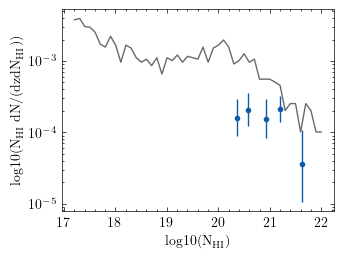

In [48]:
import matplotlib.pyplot as plt
import pickle as pickle
with plt.style.context('science','notebook'):
    plt.figure()    
    plt.plot(x_axis,y_value,color = "dimgray")
    plt.rcParams['font.size'] = 8 
    #do I use min or middle
    plt.errorbar(np.log10(H_middle),np.multiply(np.multiply(column_density_crighton_power, np.power(10,H_min)),scale_factor),yerr = np.multiply(error2,scale_factor),fmt="o",ms=3)
    plt.yscale("log")
    plt.yticks()
    plt.xlabel("$\mathrm{log10(N_{HI})}$",fontsize = 10)
    plt.ylabel("$\mathrm{log10(N_{HI}}$ $\mathrm{dN/(dzdN_{HI}))}$",fontsize =10)
    plt.savefig("f1_uniform_40.pdf")

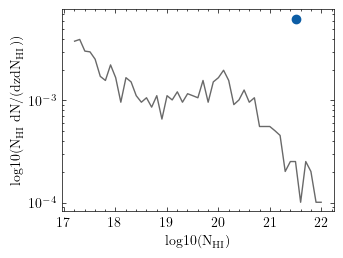

In [49]:
import matplotlib.pyplot as plt
import pickle as pickle
with plt.style.context('science','notebook'):
    plt.figure()    
    plt.plot(x_axis,y_value,color = "dimgray")
    plt.rcParams['font.size'] = 8 
    plt.scatter(21.5,10**(-23.7+21.5))
    plt.yscale("log")
    plt.yticks()
    plt.xlabel("$\mathrm{log10(N_{HI})}$",fontsize = 10)
    plt.ylabel("$\mathrm{log10(N_{HI}}$ $\mathrm{dN/(dzdN_{HI}))}$",fontsize =10)
    plt.savefig("f1_uniform_40.pdf")

In [50]:
y_value

array([0.00378766, 0.00393917, 0.00303013, 0.00297963, 0.00252511,
       0.00171707, 0.00156557, 0.00222209, 0.00166657, 0.00095954,
       0.00166657, 0.00151506, 0.00111105, 0.00095954, 0.00106055,
       0.00085854, 0.00111105, 0.00065653, 0.00111105, 0.00101004,
       0.00121205, 0.00095954, 0.00116155, 0.00111105, 0.00106055,
       0.00156557, 0.00095954, 0.00151506, 0.00166657, 0.00196958,
       0.00156557, 0.00090904, 0.00101004, 0.00126255, 0.00095954,
       0.00106055, 0.00055552, 0.00055552, 0.00055552, 0.00050502,
       0.00045452, 0.00020201, 0.00025251, 0.00025251, 0.000101  ,
       0.00025251, 0.00020201, 0.000101  , 0.000101  ])